In [1]:
import time
import os
import os.path as op

import numpy as np
import pandas as pd
import glob
import pickle

import scipy as sp
from scipy import stats
import scipy.optimize as so

import seaborn as sns
import matplotlib.pyplot as plt


# model packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# statsmodels
import statsmodels.api as sm
import statsmodels.tools as sd



#### 0. Load the data

In [2]:
# import all pkl files 

# get the project directory (cbandit)
proj_dir = os.path.normpath(os.getcwd()) #+ os.sep + os.pardir)
print(f'project directory: {proj_dir}')

f_data_all = open(proj_dir+"/joint_data_all_new2.pkl","rb")
joint_data_by_session = pickle.load(f_data_all)

f_data_by_sub = open(proj_dir+"/joint_data_by_sub.pkl","rb")
joint_data_by_sub = pickle.load(f_data_by_sub)

data_ff = pd.read_pickle('outputs_ff.p')

project directory: /Users/zoehe/Documents/GitHub/cbandit_23


In [3]:
data_ff.keys()

dict_keys(['subnums', 'subids', 'paramnames', 'parampairnames', 'tp_idx', 'params', 'params_raw', 'params_gt10', 'mdl_accuracy', 'params_alldata', 'nobs', 'reg_avg', 'reg_std', 'reg_cor', 'params_avg', 'params_ste', 'mdl_accuracy_avg', 'mdl_accuracy_ste', 'nobs_avg', 'reg_avg_avg', 'reg_std_avg', 'reg_cor_avg', 'reg_avg_ste', 'reg_std_ste', 'reg_cor_ste'])

In [5]:
data_ff['subnums']

[1,
 2,
 3,
 4,
 6,
 8,
 10,
 11,
 12,
 13,
 14,
 16,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62]

In [6]:
data_ff['reg_cor'].shape

(54, 10, 6)

In [7]:
joint_data_by_session['sub1']['sess1'].columns

Index(['index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before', 'EU_chosen

In [8]:
# define global values

# number of sessions per subject
nsess = 8 

# the valid subjects (delete invalid subjects)
valid_sub_temp = np.array(data_ff['subnums'])[:-2]
print(valid_sub_temp)
print(len(valid_sub_temp))
valid_sub_temp = np.delete(valid_sub_temp, np.where(valid_sub_temp == 35)[0][0])
#valid_sub_new = np.delete(valid_sub_temp, [17,18]) # delete sub 24, 25
#valid_sub_new_new = np.delete(valid_sub_new, 23)

valid_sub = valid_sub_temp #valid_sub_new_new
print('number of valid subjects: ', len(valid_sub))
print('valid subjects: ', valid_sub)


[ 1  2  3  4  6  8 10 11 12 13 14 16 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55 56
 57 58 59 60]
52
number of valid subjects:  51
valid subjects:  [ 1  2  3  4  6  8 10 11 12 13 14 16 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 36 37 38 39 40 41 43 44 45 47 48 49 50 51 52 53 54 55 56 57
 58 59 60]


In [9]:
joint_data_by_sub.keys()

dict_keys(['sub1', 'sub2', 'sub3', 'sub4', 'sub6', 'sub8', 'sub10', 'sub11', 'sub12', 'sub13', 'sub14', 'sub16', 'sub19', 'sub20', 'sub21', 'sub22', 'sub23', 'sub24', 'sub25', 'sub26', 'sub27', 'sub28', 'sub29', 'sub30', 'sub31', 'sub32', 'sub33', 'sub34', 'sub36', 'sub37', 'sub38', 'sub39', 'sub40', 'sub41', 'sub43', 'sub44', 'sub45', 'sub47', 'sub48', 'sub49', 'sub50', 'sub51', 'sub52', 'sub53', 'sub54', 'sub55', 'sub56', 'sub57', 'sub58', 'sub59', 'sub60'])

In [10]:
# combine all sessions to get a single dataframe

# 1. combine across sessions for each subject
joint_data_all = pd.DataFrame()
for sub in valid_sub-1:
    joint_data_each_sub = pd.DataFrame()

    sample_data = joint_data_by_sub[f'sub{sub+1}']
    sample_data['sub'] = (np.ones(len(sample_data)) * (sub+1)).astype(int)
    
    joint_data_all = pd.concat([joint_data_all, sample_data], axis=0)
    
joint_data_all = joint_data_all.reset_index(drop = True)

### 1. Expected uncertainty (EU)

#### 1.1 Overall trend: whether pupil size is larger for trials with larger EU.
- For each subject, bin the trials into K bins based on EU (after), compute the average EU and average pupil (after outcome on t)) for each bin; let K = 7 (same as Alex's paper).
- next step: try other combinations of EU measures and pupil measures

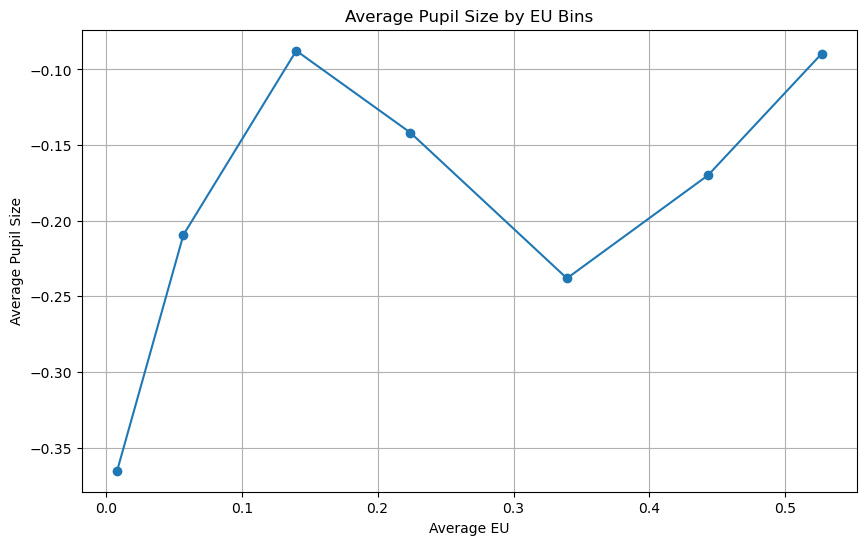

In [11]:
# step 1: combine all sessions for each subject: DONE with joint_data_by_sub

# step 2: group the trials based on EU

def plot_average_pupil_size(df, xlabel, ylabel):
    # Bin the 'EU' column into 7 bins and create a new column for these bins
    df['EU_bins'] = pd.qcut(df[xlabel], q=7)

    # Group by the bins and calculate the mean for 'EU' and 'pupil_size'
    grouped = df.groupby('EU_bins').agg({xlabel: 'mean', ylabel: 'mean'})

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(grouped[xlabel], grouped[ylabel], marker='o')
    plt.xlabel('Average EU')
    plt.ylabel('Average Pupil Size')
    plt.title('Average Pupil Size by EU Bins')
    plt.grid(True)
    plt.show()

# Example usage
plot_average_pupil_size(joint_data_by_sub['sub1'], 'EU_chosen_after', 'pupil_size_avg_outcome')

In [12]:
def plot_average_values(df, x_col, y_col):
    df['bins'] = pd.qcut(df[x_col], q=7, duplicates='drop')
    grouped = df.groupby('bins').agg({x_col: 'mean', y_col: 'mean'})
    #print(grouped)
    return grouped

def combine_and_plot(dataframes_dict, xlabel, ylabel):
    all_grouped = pd.DataFrame()

    for key, df in dataframes_dict.items():
        grouped = plot_average_values(df, xlabel, ylabel)
        grouped['subject'] = key
        all_grouped = pd.concat([all_grouped, grouped], axis=0)

    # Drop the 'subject' column before calculating the overall average
    overall_average = all_grouped.drop(columns='subject').groupby('bins').mean()

    # Plotting
    plt.figure(figsize=(12, 8))

    # Plot each subject
    for key in dataframes_dict.keys():
        subject_group = all_grouped[all_grouped['subject'] == key]
        plt.plot(subject_group[xlabel], subject_group[ylabel], marker='o', alpha=0.5)

    # Plot overall average
    plt.plot(overall_average[xlabel], overall_average[ylabel], marker='o', color='black', linewidth=2, label='Overall Average')

    plt.xlabel(f'Average {xlabel}')
    plt.ylabel(f'Average {ylabel}')
    plt.title(f'Average {ylabel} by {xlabel} Bins Across Subjects')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Statistical Test for Correlation
    correlation, p_value = stats.pearsonr(all_grouped[xlabel], all_grouped[ylabel])
    print(f"Pearson Correlation Coefficient: {correlation}, P-value: {p_value}")


In [3]:
joint_data_by_sub

NameError: name 'joint_data_by_sub' is not defined

In [56]:
def find_common_bins(dataframes_dict, x_col, n_bins):
    # Combine all x_col data to find common bin edges
    all_data_list = []

    for item in dataframes_dict.values():
        # Check if the item is a DataFrame and contains the required column
        if isinstance(item, pd.DataFrame) and x_col in item.columns:
            all_data_list.append(item[x_col])
        # If the item is a NumPy array, assume it corresponds to the data of interest
        elif isinstance(item, np.ndarray):
            all_data_list.append(pd.Series(item))
        else:
            print("Warning: An item in the dictionary is neither a pandas DataFrame nor a NumPy array.")


    all_data = pd.concat([df[x_col] for df in dataframes_dict.values()])
    print(all_data)
    bin_edges = pd.qcut(all_data, q=n_bins, duplicates='drop', retbins=True)[1]
    return bin_edges

def plot_average_values(df, x_col, y_col, bin_edges):
    # Handle NaNs in the DataFrame
    df = df.dropna(subset=[x_col, y_col])

    # Ensure there are no inf values
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[x_col, y_col])


    df['bins'] = pd.cut(df[x_col], bins=bin_edges, include_lowest=True)
    grouped = df.groupby('bins').agg({x_col: 'mean', y_col: 'mean'}).reset_index()
    return grouped

def filter_trials(dataframes_dict, condition='free'):
    dataframes_filtered = {}
    for key, df in dataframes_dict.items():
        df_new = df[df[condition]==1]
        dataframes_filtered[key] = df_new
    return dataframes_filtered

def combine_and_plot(dataframes_dict, xlabel, ylabel, n_bins=7, condition=None):
    if condition is not None:
        dataframes_dict = filter_trials(dataframes_dict)

    bin_edges = find_common_bins(dataframes_dict, xlabel, n_bins)
    all_grouped = pd.DataFrame()

    for key, df in dataframes_dict.items():
        grouped = plot_average_values(df, xlabel, ylabel, bin_edges)
        grouped['subject'] = key
        all_grouped = pd.concat([all_grouped, grouped], axis=0)

    # Drop the 'subject' column before calculating the overall average
    overall_average = all_grouped.drop(columns='subject').groupby('bins').mean()

    # Plotting
    plt.figure(figsize=(7, 5))

    # Plot each subject (based on condition)
    for key in dataframes_dict.keys():
        subject_group = all_grouped[all_grouped['subject'] == key]
        plt.plot(subject_group[xlabel], subject_group[ylabel], marker='o', color='grey', alpha=0.5)#, label=key)

    # Plot overall average
    plt.plot(overall_average[xlabel], overall_average[ylabel], marker='o', color='black', linewidth=2, label='Overall Average')

    plt.xlabel(f'Average {xlabel}')
    plt.ylabel(f'Average {ylabel}')
    plt.title(f'Average {ylabel} by {xlabel} Bins Across Subjects')
    plt.legend()
    plt.legend( prop={'size': 16})
    plt.grid(True)
    plt.ylim(-0.98, 0.63)
    plt.show()

    # Prepare data for correlation calculation
    clean_data = all_grouped.dropna(subset=[xlabel, ylabel])
    clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna(subset=[xlabel, ylabel])

    # Ensure there is enough data for correlation calculation
    if len(clean_data) > 1:
        correlation, p_value = stats.pearsonr(clean_data[xlabel], clean_data[ylabel])
        print(f"Pearson Correlation Coefficient: {correlation}, P-value: {p_value}")
    else:
        print("Not enough data to compute Pearson correlation.")
        

0      1.216040
1      1.190135
2      1.109338
3      0.757907
4      0.877393
5      0.775311
6      0.788971
7      0.895700
8      1.175828
9      1.143230
10     1.046239
11     1.053656
12     0.892950
13     1.048346
14     0.892825
15     0.851157
16     0.831068
17     0.895679
18     1.017884
19     1.069373
20     1.003916
21     1.097949
22     1.102528
23     1.083520
24     1.042140
25     1.023001
26     0.715869
27     0.946304
28     0.676645
29     0.757347
30     0.787531
31     0.886328
32     0.678349
33     0.857189
34     1.197360
35     1.155712
36     1.140513
37     1.067447
38     1.055341
39     1.114522
40     0.852624
41     0.663366
42     0.988693
43     0.740732
44     0.675005
45     0.701907
46     0.735881
47     0.925846
48     0.739455
49     0.967246
50     0.968498
51     0.762569
52     0.351081
53     0.653131
54     0.504600
55     0.773849
56     0.671778
57     0.566922
58     0.581860
59     0.634254
60     0.555476
61     0.457969
62     0

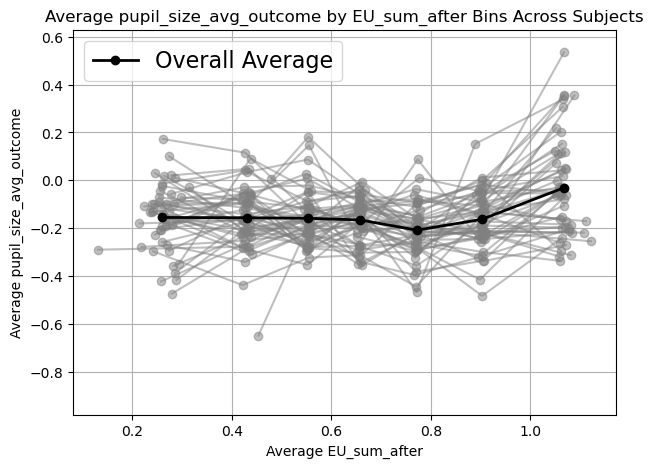

Pearson Correlation Coefficient: 0.17005406117280286, P-value: 0.0013197263143388588


In [59]:
combine_and_plot(joint_data_by_sub, 'EU_sum_after', 'pupil_size_avg_outcome')

In [52]:
joint_data_by_sub_test = filter_trials(joint_data_by_sub, condition='free')


In [49]:
joint_data_by_sub_test['sub1'].head()

level_0  index  trial     rt  \
4        4      4      4  1.754   
5        5      5      5  0.670   
6        6      6      6  0.608   
7        7      7      7  0.481   
8        8      8      8  0.389   

                                pupil_baseline_start  \
4  [0.7752312920948785, 0.8033788108457145, 0.831...   
5  [-0.014070726429944093, 0.07200551558362626, 0...   
6  [0.5645306435758504, 0.5220559070389464, 0.529...   
7  [0.812434679369609, 0.8352830421112023, 0.8376...   
8  [-0.9093350826422794, -0.9180967001639865, -0....   

                              pupil_baseline_outcome  \
4  [0.467254551806917, 0.46196730826422516, 0.473...   
5  [0.6338147425105218, 0.6299372927579306, 0.644...   
6  [0.24955365242458305, 0.19881561613871465, 0.0...   
7  [0.5712231006447698, 0.577490497826667, 0.5418...   
8  [-0.7132004617980368, -0.6817428016889201, -0....   

                             pupil_size_pre_response  \
4  [0.13627293908167493, 0.0938579818830942, 0.08...   
5  [0.4760234090306778, 0.4913268935299456, 0.511...   
6  [0.9115368366950517, 0.8777996152277876, 0.872...   
7  [0.7131395321658324, 0.7152599832605447, 0.681...   
8  [-1.1494335599131758, -1.1329923945209055, -1....   

   pupil_size_avg_pre_response  \
4                    -0.051292   
5                     0.630158   
6                     0.909284   
7                     0.907147   
8                    -0.972158   

                                 pupil_size_response  pupil_size_avg_response  \
4  [-0.1988164400882881, -0.1855046140065632, -0....                 0.438572   
5  [0.6647135970850474, 0.6408346787178851, 0.648...                 0.430578   
6  [0.9120791004495411, 0.9305388167788239, 0.943...                 0.434339   
7  [1.036591388601392, 1.051552335933031, 1.09038...                 0.743148   
8  [-0.8604287489180725, -0.8372131509992409, -0....                -0.524359   

                                  pupil_size_outcome  pupil_size_avg_outcome  \
4  [0.467254551806917, 0.46196730826422516, 0.473...               -0.281571   
5  [0.6338147425105218, 0.6299372927579306, 0.644...                0.753913   
6  [0.24955365242458305, 0.19881561613871465, 0.0...                0.422503   
7  [0.5712231006447698, 0.577490497826667, 0.5418...               -0.507803   
8  [-0.7132004617980368, -0.6817428016889201, -0....               -0.494847   

   pupil_baseline_start_avg  pupil_baseline_outcome_avg  \
4                  0.856633                    0.453007   
5                  0.140097                    0.637999   
6                  0.568525                    0.095124   
7                  0.803631                    0.514319   
8                 -0.958852                   -0.706443   

                           pupil_change_pre_response  \
4  [-0.7203595828075425, -0.7627745400061232, -0....   
5  [0.33592610414489055, 0.3512295886441583, 0.37...   
6  [0.34301166387484017, 0.30927444240757607, 0.3...   
7  [-0.09049183953868623, -0.08837138844397385, -...   
8  [-0.19058118267167057, -0.17414001727940032, -...   

   pupil_change_avg_pre_response  \
4                      -0.907925   
5                       0.490061   
6                       0.340759   
7                       0.103516   
8                      -0.013306   

                               pupil_change_response  \
4  [-1.0554489619775056, -1.0421371358957807, -0....   
5  [0.5246162921992601, 0.5007373738320979, 0.507...   
6  [0.34355392762932957, 0.36201364395861235, 0.3...   
7  [0.2329600168968734, 0.2479209642285124, 0.286...   
8  [0.09842362832343265, 0.12163922624226431, 0.1...   

   pupil_change_avg_response  \
4                  -0.418061   
5                   0.290481   
6                  -0.134186   
7                  -0.060483   
8                   0.434493   

                                pupil_change_outcome  \
4  [0.01424757300069951, 0.008960329458007676, 0....   
5  [-0.004184351902634997, -0.008061801655226186,...   
6

In [57]:
combine_and_plot(joint_data_by_sub, 'EU_sum_after', 'pupil_size_avg_outcome', 'free')

0      1.216040
1      1.190135
2      1.109338
3      0.757907
4      0.877393
5      0.775311
6      0.788971
7      0.895700
8      1.175828
9      1.143230
10     1.046239
11     1.053656
12     0.892950
13     1.048346
14     0.892825
15     0.851157
16     0.831068
17     0.895679
18     1.017884
19     1.069373
20     1.003916
21     1.097949
22     1.102528
23     1.083520
24     1.042140
25     1.023001
26     0.715869
27     0.946304
28     0.676645
29     0.757347
30     0.787531
31     0.886328
32     0.678349
33     0.857189
34     1.197360
35     1.155712
36     1.140513
37     1.067447
38     1.055341
39     1.114522
40     0.852624
41     0.663366
42     0.988693
43     0.740732
44     0.675005
45     0.701907
46     0.735881
47     0.925846
48     0.739455
49     0.967246
50     0.968498
51     0.762569
52     0.351081
53     0.653131
54     0.504600
55     0.773849
56     0.671778
57     0.566922
58     0.581860
59     0.634254
60     0.555476
61     0.457969
62     0

TypeError: '<=' not supported between instances of 'int' and 'numpy.ndarray'

In [17]:
# idea 1: separate the trials into: 
# (1) whether trial t+1 selects the option with larger EU?

# idea 2: individual differences?

In [16]:
joint_data_by_sub['sub1'].iloc[96]['switch_next']

True

In [17]:

for s in valid_sub:
    data_per_sub = joint_data_by_sub[f'sub{s}']

    choose_large_EU_next = np.zeros(len(data_per_sub))
    for i in range(len(data_per_sub)):
        if data_per_sub.iloc[i]['index'] != 95: # make sure it is not the last trial of the session
            if data_per_sub.iloc[i+1]['EU_diff_before'] > 0: # check whether the NEXT chosen option has larger EU (positive diff)
                choose_large_EU_next[i] = 1
        else:
            choose_large_EU_next[i] = np.nan
                
    joint_data_by_sub[f'sub{s}']['choose_large_EU_next'] = choose_large_EU_next

In [18]:
pd.set_option('display.max_columns', None)
data_per_sub

level_0  index  trial      rt  \
0          0      0      0  14.307   
1          1      1      1   1.950   
2          2      2      2   1.203   
3          3      3      3   0.836   
4          4      4      4   0.886   
..       ...    ...    ...     ...   
763       91     91     91   1.142   
764       92     92     92   0.316   
765       93     93     93   0.412   
766       94     94     94   0.319   
767       95     95     95   0.325   

                                  pupil_baseline_start  \
0    [0.4512524809076589, 0.47358640073485514, 0.47...   
1    [0.3728106435716297, 0.30595267957474026, 0.26...   
2    [0.4531594955862836, 0.4505523408239858, 0.446...   
3    [0.2493712974503475, 0.1797073611349643, 0.160...   
4    [0.2329468694457934, 0.2195645528616627, 0.246...   
..                                                 ...   
763  [0.67943674845904, 0.7272363341078137, 0.73705...   
764  [-0.17780774209706132, -0.13794868236501812, -...   
765  [-1.203478368664157, -1.1643138433366318, -1.1...   
766  [-1.6546526797253853, -1.6049083492062692, -1....   
767  [0.5476487169455556, 0.40803424555855716, 0.35...   

                                pupil_baseline_outcome  \
0    [1.3595958934327117, 1.375846837164174, 1.3522...   
1    [0.16848354928987766, 0.17813835699020253, 0.1...   
2    [-0.9279685749872779, -0.9453852131180074, -0....   
3    [-0.6720455772971883, -0.7191280822572133, -0....   
4    [1.7544874871463856, 1.7720780239957616, 1.805...   
..                                                 ...   
763  [0.5511960490811909, 0.5499120983188762, 0.581...   
764  [-0.8800874249291134, -0.863458312754363, -0.8...   
765  [-3.327919441521653, -3.3458417071503943, -3.3...   
766  [-0.23448572896024178, -0.11422985799373579, -...   
767  [-0.6308113880375159, -0.6443178855941037, -0....   

                               pupil_size_pre_response  \
0    [0.9012625772442107, 0.923419756338039, 0.9813...   
1    [0.13093264392753065, 0.14002343053940322, 0.1...   
2    [0.8564177916882505, 0.874603580597752, 0.9877...   
3    [1.0092325215058655, 1.0060257517126063, 1.014...   
4    [0.8322483658106244, 0.8368113607088992, 0.775...   
..                                                 ...   
763  [1.0707077050777225, 1.0654853260524422, 1.070...   
764  [-0.14873885096615147, -0.11531997069426185, -...   
765  [-1.1940200358695918, -1.1961699578124045, -1....   
766  [-1.558495613955596, -1.5328490750914376, -1.4...   
767  [0.41406870553831127, 0.3766595113669954, 0.35...   

     pupil_size_avg_pre_response  \
0                       1.090340   
1                       0.347182   
2                       0.664230   
3                       1.172001   
4                       0.847741   
..                           ...   
763                     1.213163   
764                     0.221271   
765                    -1.551658   
766                    -1.222526   
767                     0.228686   

                                   pupil_size_response  \
0    [1.1884758345129462, 1.1722194968436488, 1.195...   
1    [0.49289570133733357, 0.5141890876747841, 0.56...   
2    [0.4956462720515597, 0.4535649306316723, 0.427...   
3    [1.3851556862149352, 1.388967864655642, 1.3178...   
4    [0.8457479447273881, 0.872420260350685, 0.9672...   
..                                                 ...   
763  [1.3801842435307121, 1.323949527624748, 1.1854...   
764  [0.32346568708713375, 0.35393766046567277, 0.4...   
765  [-1.7172245184480575, -1.7368905531884036, -1....   
766  [-1.106845834894351, -1.1308387794174326, -1.1...   
767  [0.11716046275001123, 0.10990970946557645, 0.1...   

     pupil_size_avg_response  \
0                   1.232890   
1                   0.340092   
2                  -0.219130   
3                   0.612900   
4                   1.237052   
..                       ...   
763                 0.497171   
764                 0.406316   
765                -2.623501   
766    

In [24]:
pd.set_option('display.max_row', None)

joint_data_by_sub[f'sub60']['choose_large_EU_next'][0]

1.0

In [54]:
def find_common_bins(dataframes_dict, x_col, n_bins):
    all_data_list = []

    for item in dataframes_dict.values():
        # Check if the item is a DataFrame and contains the required column
        if isinstance(item, pd.DataFrame) and x_col in item.columns:
            all_data_list.append(item[x_col])
        # If the item is a NumPy array, assume it corresponds to the data of interest
        elif isinstance(item, np.ndarray):
            all_data_list.append(pd.Series(item))
        else:
            print("Warning: An item in the dictionary is neither a pandas DataFrame nor a NumPy array.")

    all_data = pd.concat(all_data_list)
    bin_edges = pd.qcut(all_data, q=n_bins, duplicates='drop', retbins=True)[1]
    return bin_edges

def plot_average_values(df, x_col, y_col, bin_edges, condition):
    # Filter based on the condition
    df = df[df['choose_large_EU_next'] == condition].copy()

    df['bins'] = pd.cut(df[x_col], bins=bin_edges, include_lowest=True)
    grouped = df.groupby('bins').agg({x_col: 'mean', y_col: 'mean'}).reset_index()
    return grouped

def filter_trials(dataframes_dict):
    dataframes_filtered = {}
    for key, df in dataframes_dict.items():
        df_new = df[df['trial_forced']==1]
        dataframes_filtered[key] = df_new
    return dataframes_filtered

def combine_and_plot2(dataframes_dict, xlabel, ylabel, n_bins=7, free=False):
    if free == True:
        dataframes_dict = filter_trials(dataframes_dict)
    bin_edges = find_common_bins(dataframes_dict, xlabel, n_bins)

    # Initialize DataFrames for overall averages
    overall_average_0 = pd.DataFrame()
    overall_average_1 = pd.DataFrame()

    # Initialize DataFrames for data collection
    data_for_test_0 = {i: [] for i in range(n_bins)}  # For condition 0
    data_for_test_1 = {i: [] for i in range(n_bins)}  # For condition 1


    # Plotting
    plt.figure(figsize=(7, 5))

    for key, df in dataframes_dict.items():
        for condition, color in zip([0, 1], ['cornflowerblue', 'burlywood']):
            # Ensure that the DataFrame contains the relevant condition
            #print('key', key)
            #print('condition', condition)
            if condition in df['choose_large_EU_next'].unique():

                grouped = plot_average_values(df, xlabel, ylabel, bin_edges, condition)
                plt.plot(grouped[xlabel], grouped[ylabel], marker='o',alpha=0.5, color=color) #, label=f'{key} Condition {condition}')

                # Append to overall average DataFrame
                if condition == 0:
                    overall_average_0 = pd.concat([overall_average_0, grouped], axis=0)
                else:
                    overall_average_1 = pd.concat([overall_average_1, grouped], axis=0)

                # Collect data for t-test
                for bin_index, row in grouped.iterrows():
                    if condition == 0:
                        data_for_test_0[bin_index].append(row[ylabel])
                    else:
                        data_for_test_1[bin_index].append(row[ylabel])

            #print('done')

    # Plot overall average lines with error bars
    conditions = ['choosing low EU option next trial', 'choosing high EU option next trial']
    for overall_avg, color, condition in zip([overall_average_0, overall_average_1], ['navy', 'brown'], [0, 1]):
        if not overall_avg.empty:
            #overall_avg_grouped = overall_avg.groupby('bins').agg({ylabel: ['mean', 'sem']})
            #overall_avg_grouped.columns = overall_avg_grouped.columns.droplevel(0)

            # Calculate midpoints of bins for plotting
            #midpoints = [(interval.left + interval.right) / 2 for interval in overall_avg_grouped.index]
            #overall_avg_grouped.reset_index(drop=True, inplace=True)

            overall_avg = overall_avg.groupby('bins').mean().reset_index()
            plt.plot(overall_avg[xlabel], overall_avg[ylabel], marker='o', linewidth=4, color=color, label=f'Mean {conditions[condition]}')

            #plt.errorbar(midpoints, overall_avg_grouped['mean'], yerr=overall_avg_grouped['sem'], fmt='o', color=color, label=f'Overall Average Condition {condition}')
        else:
            print(f"No data to plot for condition {condition}")

        #if not overall_avg.empty:

    plt.xlabel(f'Average {xlabel}')
    plt.ylabel(f'Average {ylabel}')
    plt.title(f'Average {ylabel} by {xlabel} Bins Across Subjects and Conditions')
    plt.legend()
    plt.legend( prop={'size': 16})

    plt.grid(True)
    plt.show()

    # Perform statistical tests for each condition
    for condition, overall_avg in zip([0, 1], [overall_average_0, overall_average_1]):
        if not overall_avg.empty:
            clean_data = overall_avg.dropna(subset=[xlabel, ylabel])
            clean_data = clean_data.replace([np.inf, -np.inf], np.nan).dropna(subset=[xlabel, ylabel])
            if len(clean_data) > 1:
                correlation, p_value = stats.pearsonr(clean_data[xlabel], clean_data[ylabel])
                print(f"Condition {conditions[condition]}: Pearson Correlation Coefficient: {correlation}, P-value: {p_value}")
            else:
                print(f"Condition {conditions[condition]}: Not enough data to compute Pearson correlation.")
    
    # Perform paired t-tests for each bin
    for bin_index in range(n_bins):
        data_0 = data_for_test_0[bin_index]
        data_1 = data_for_test_1[bin_index]

        if data_0 and data_1:
            t_statistic, p_value = stats.ttest_rel(data_0, data_1, nan_policy='omit')
            print(f"Bin {bin_index}: t-statistic = {t_statistic}, p-value = {p_value}")
        else:
            print(f"Bin {bin_index}: Insufficient data for paired t-test.")



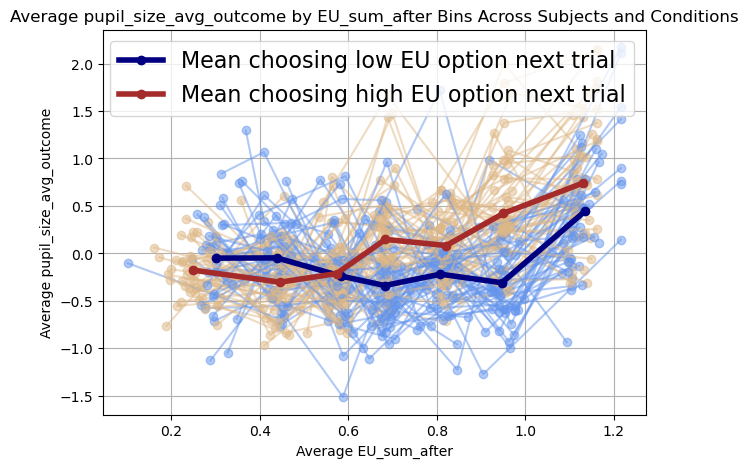

Condition choosing low EU option next trial: Pearson Correlation Coefficient: 0.1908117219994079, P-value: 0.0004541982630486755
Condition choosing high EU option next trial: Pearson Correlation Coefficient: 0.5607581956334688, P-value: 1.0468029499314397e-30
Bin 0: t-statistic = 1.4688935659366256, p-value = 0.14988228699366524
Bin 1: t-statistic = 3.2803448782227584, p-value = 0.0020064891918998673
Bin 2: t-statistic = -0.2831182649134301, p-value = 0.7783294718581125
Bin 3: t-statistic = -5.145768772105314, p-value = 4.683644268604287e-06
Bin 4: t-statistic = -3.567774392359641, p-value = 0.0008051307990369319
Bin 5: t-statistic = -6.687563564089148, p-value = 2.4360089092030176e-08
Bin 6: t-statistic = -2.708073357892593, p-value = 0.009239490207520596


In [55]:
combine_and_plot2(joint_data_by_sub, 'EU_sum_after', 'pupil_size_avg_outcome', free=True)

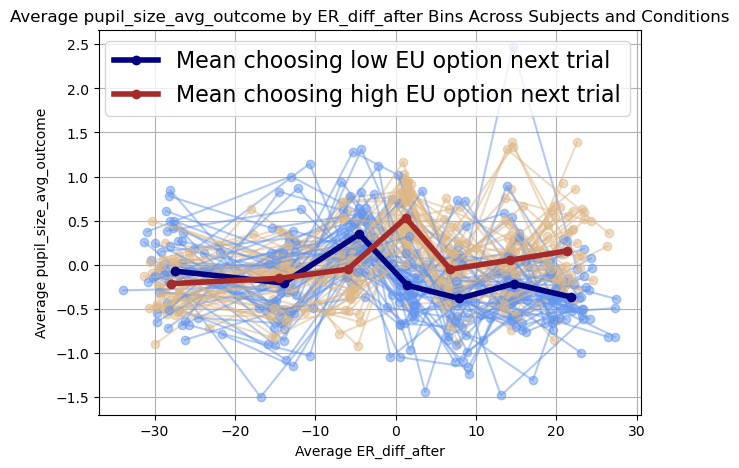

Condition choosing low EU option next trial: Pearson Correlation Coefficient: -0.20348677996276457, P-value: 0.00011813477521386876
Condition choosing high EU option next trial: Pearson Correlation Coefficient: 0.2751907044445705, P-value: 1.2659948077037358e-07
Bin 0: t-statistic = 2.088317075561313, p-value = 0.04188236915210623
Bin 1: t-statistic = -0.5897432543412278, p-value = 0.5580185343417833
Bin 2: t-statistic = 5.885947844895388, p-value = 3.290201232874266e-07
Bin 3: t-statistic = -8.44428063385528, p-value = 4.7321863217953096e-11
Bin 4: t-statistic = -3.861872608470594, p-value = 0.00033644024920957363
Bin 5: t-statistic = -2.5754022750269376, p-value = 0.013016589935019168
Bin 6: t-statistic = -7.990428941954277, p-value = 1.7209533203845276e-10


In [36]:
combine_and_plot2(joint_data_by_sub, 'ER_diff_after', 'pupil_size_avg_outcome', free=True)

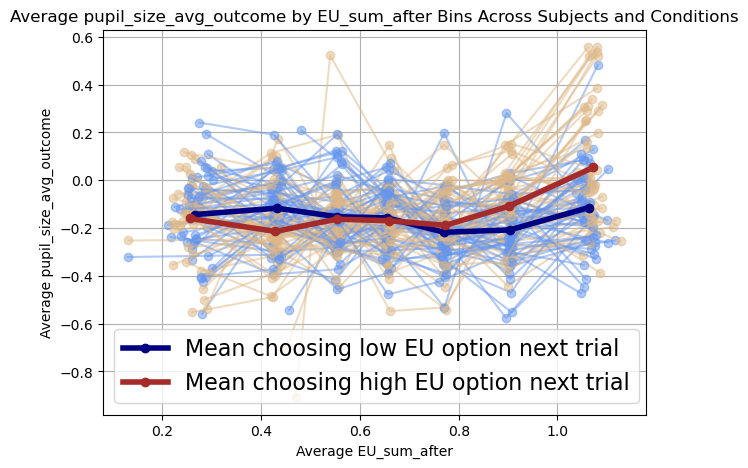

Condition choosing low EU option next trial: Pearson Correlation Coefficient: -0.05748594264741492, P-value: 0.28074005015751524
Condition choosing high EU option next trial: Pearson Correlation Coefficient: 0.3138665008122972, P-value: 1.56303213637085e-09
Bin 0: t-statistic = 0.608228847342249, p-value = 0.5459639339579748
Bin 1: t-statistic = 3.187754887040974, p-value = 0.0024734914156671105
Bin 2: t-statistic = 0.4234309672672053, p-value = 0.6737967755297403
Bin 3: t-statistic = 0.47691576318608203, p-value = 0.6355000066405627
Bin 4: t-statistic = -1.3335070166289251, p-value = 0.1884089238087985
Bin 5: t-statistic = -4.242096742077605, p-value = 9.559141151248954e-05
Bin 6: t-statistic = -6.588622886729263, p-value = 2.6421127196721274e-08


In [23]:
combine_and_plot2(joint_data_by_sub, 'EU_sum_after', 'pupil_size_avg_outcome', free=False)

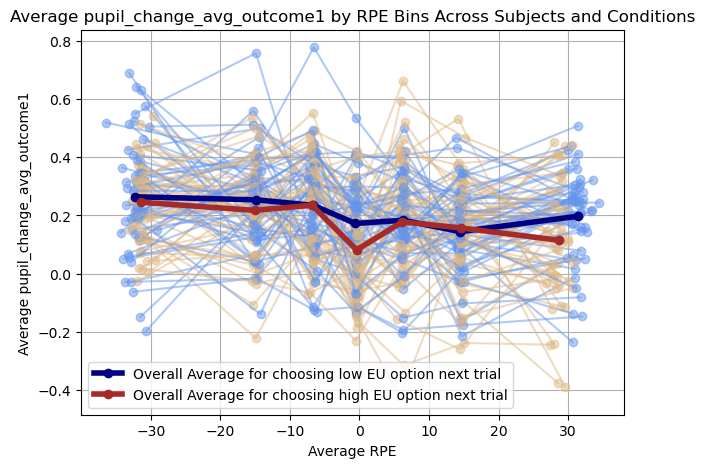

Condition choosing low EU option next trial: Pearson Correlation Coefficient: -0.1823536641092102, P-value: 0.0005352558194979617
Condition choosing high EU option next trial: Pearson Correlation Coefficient: -0.2223654165236673, P-value: 2.2358205220844047e-05
Bin 0: t-statistic = 0.6687298320693376, p-value = 0.5067437033582111
Bin 1: t-statistic = 1.4740808627344602, p-value = 0.14672851429375625
Bin 2: t-statistic = -0.010118277050264255, p-value = 0.9919671854287123
Bin 3: t-statistic = 4.026540542045804, p-value = 0.00019215565639817922
Bin 4: t-statistic = 0.21296909356858543, p-value = 0.8322170184568978
Bin 5: t-statistic = -0.4670987538624868, p-value = 0.6424584197465855
Bin 6: t-statistic = 2.8671335978314567, p-value = 0.006048051956948703


In [178]:
combine_and_plot2(joint_data_by_sub, 'RPE', 'pupil_change_avg_outcome1')

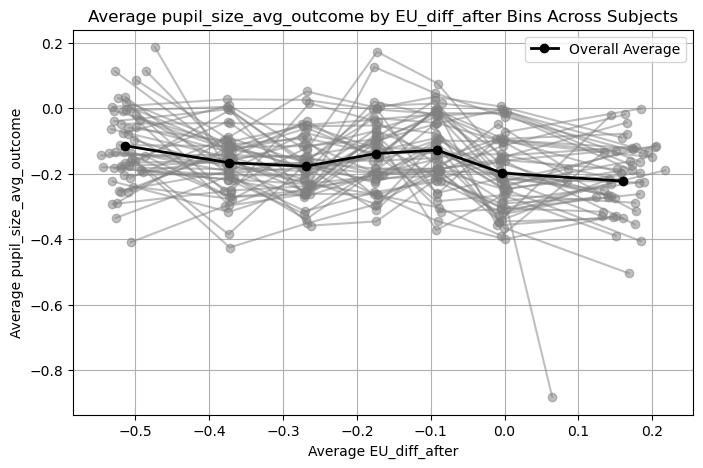

Pearson Correlation Coefficient: -0.2025758959601079, P-value: 0.00011612307187531255


In [95]:
combine_and_plot(joint_data_by_sub, 'EU_diff_after', 'pupil_size_avg_outcome')

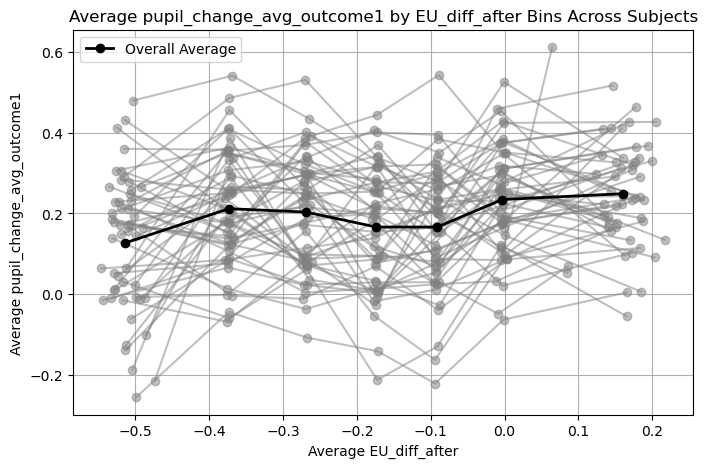

Pearson Correlation Coefficient: 0.18369420954800464, P-value: 0.00048599880636110144


In [101]:
combine_and_plot(joint_data_by_sub, 'EU_diff_after', 'pupil_change_avg_outcome1')

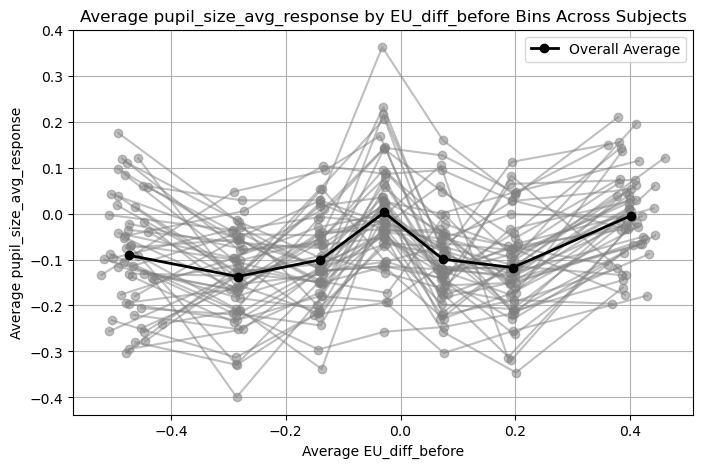

Pearson Correlation Coefficient: 0.19495491213082056, P-value: 0.00021033451409341384


In [103]:
combine_and_plot(joint_data_by_sub, 'EU_diff_before', 'pupil_size_avg_response')

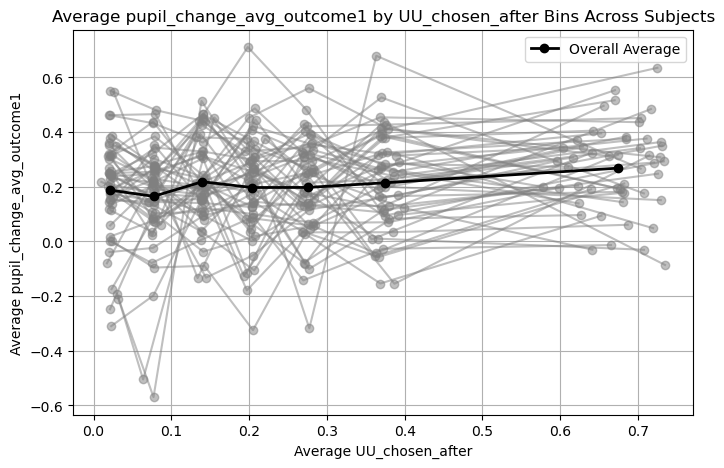

Pearson Correlation Coefficient: 0.14872334406494925, P-value: 0.0048645956317411474


In [108]:
combine_and_plot(joint_data_by_sub, 'UU_chosen_after', 'pupil_change_avg_outcome1')

#### 1.2 First free trial

In [170]:
joint_data_by_sub['sub1'].columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [172]:
joint_data_by_sub['sub1'].head(20)

level_0  index  trial     rt  \
0         0      0      0  0.873   
1         1      1      1  0.503   
2         2      2      2  0.948   
3         3      3      3  0.633   
4         4      4      4  1.754   
5         5      5      5  0.670   
6         6      6      6  0.608   
7         7      7      7  0.481   
8         8      8      8  0.389   
9         9      9      9  0.419   
10       10     10     10  0.613   
11       11     11     11  0.444   
12       12     12     12  0.554   
13       13     13     13  0.558   
14       14     14     14  0.486   
15       15     15     15  0.354   
16       16     16     16  0.347   
17       17     17     17  0.499   
18       18     18     18  0.477   
19       19     19     19  1.328   

                                 pupil_baseline_start  \
0   [-0.13285487334831725, -0.15435727323074105, -...   
1   [0.14530678606560862, 0.1443430154502174, 0.24...   
2   [0.22792893919942742, 0.15482785060969537, 0.1...   
3   [-0.04115643605480424, -0.011971396588699315, ...   
4   [0.7752312920948785, 0.8033788108457145, 0.831...   
5   [-0.014070726429944093, 0.07200551558362626, 0...   
6   [0.5645306435758504, 0.5220559070389464, 0.529...   
7   [0.812434679369609, 0.8352830421112023, 0.8376...   
8   [-0.9093350826422794, -0.9180967001639865, -0....   
9   [-0.19362062819443376, -0.20357179674501238, -...   
10  [0.9201719223618946, 0.9194391848403354, 0.948...   
11  [-0.07679125341811124, -0.06375129367534113, -...   
12  [0.354444996409943, 0.3520804332066494, 0.3803...   
13  [-0.7494110416854559, -0.7451891836966367, -0....   
14  [-0.7020659278979556, -0.6277981849101277, -0....   
15  [0.18165628470654321, 0.10152079419107624, 0.0...   
16  [0.530294335180079, 0.536339566501282, 0.57477...   
17  [0.607213581663082, 0.644776974974691, 0.66648...   
18  [-1.9937232377759713, -2.0047425012247477, -2....   
19  [-0.867798450169664, -0.8884559368905478, -0.8...   

                               pupil_baseline_outcome  \
0   [0.07491006887873684, 0.13786000971694218, 0.1...   
1   [0.23190501894722576, 0.17961922205809192, 0.1...   
2   [0.1730485920638111, 0.15684330963330576, 0.18...   
3   [-0.02837186777614119, 0.004751287527410095, 0...   
4   [0.467254551806917, 0.46196730826422516, 0.473...   
5   [0.6338147425105218, 0.6299372927579306, 0.644...   
6   [0.24955365242458305, 0.19881561613871465, 0.0...   
7   [0.5712231006447698, 0.577490497826667, 0.5418...   
8   [-0.7132004617980368, -0.6817428016889201, -0....   
9   [0.9388166300308288, 0.9998741509209392, 1.033...   
10  [0.7676225703336175, 0.7800258694991125, 0.860...   
11  [-1.0765192283281582, -1.073275586100938, -1.0...   
12  [-2.3028009346901306, -2.3380241843191816, -2....   
13  [0.3700020624590637, 0.3776666187779465, 0.376...   
14  [1.0721002807494289, 1.1082195879829502, 1.169...   
15  [0.1500092391812842, 0.12729275360911219, 0.13...   
16  [-1.1667117639717957, -1.1564095532829801, -1....   
17  [-0.18476272061243823, -0.13438405745276555, -...   
18  [-0.20602955194123987, -0.18720309012501105, -...   
19  [-1.234388825363799, -1.2261042287342598, -1.1...   

                              pupil_size_pre_response  \
0   [0.11437311041501608, 0.10994014858446984, 0.1...   
1   [0.34474857188501473, 0.35575292963603705, 0.3...   
2   [-0.5578585701312097, -0.5368051541620953, -0....   
3   [0.9398780279838435, 0.9354819044102489, 0.927...   
4   [0.13627293908167493, 0.0938579818830942, 0.08...   
5   [0.4760234090306778, 0.4913268935299456, 0.511...   
6   [0.9115368366950517, 0.8777996152277876, 0.872...   
7   [0.7131395321658324, 0.7152599832605447, 0.681...   
8   [-1.1494335599131758, -1.1329923945209055, -1....   
9   [-0.009637713236125894, 0.009984718452773893, ...   
10  [1.4589632788305194, 1.5148772882774049, 1.524...   
11  [0.007610449872303222, -0.03282676411196229, -...   
12  [0.8586895594919514, 0.8379772583334405, 0.825...   
13  [-0.4298012774313076, -0.4738167557851365, -0....

In [187]:
# find all the forced trial blocks with the first free

# copy & paste from previous behavioral analysis

# forced = ~kept and ~missedresponse # 4 trials per group
# even observations?
# avg rewards observed for each arm?
# use the above info to figure out the 
NUM_FREE_CHOICES = 3
df_forced = pd.DataFrame(columns = ['sub', 'ratio_B', 'avg_reward_A', 'avg_reward_B', 'first_free_choice', f'first_{NUM_FREE_CHOICES}_choices'])

for isub in valid_sub:
    print(f'subject {isub}...')
    for isess in range(1):
    
        behavioral_data1 = joint_data_by_sub[f'sub{isub}']
        #behavioral_data1 = df_all_sub[]
        #behavioral_data1['forced'] = np.multiply(~behavioral_data1['kept'], ~behavioral_data1['missedresponse'])
        #behavioral_data1['choices'][forced_trials]

        reward_list = behavioral_data1['outcomes']
        ntrials = len(behavioral_data1['choices_new'])

        for t in range(ntrials):
            # find the forced trial window:
            #if behavioral_data1['forced'][t] and (t == 0 or ~behavioral_data1['forced'][t-1]): # locate the first forced trial in each forced group
            if behavioral_data1['trial_forced'][t] == 1: # locate the first forced trial

                t_forced_end = t
                forced_cont = True
                # iterate to find the window range for the current forced group
                while forced_cont:
                    t_forced_end += 1
                    if ~behavioral_data1['forced'][t_forced_end]:
                        # if no longer forced trial, exit the forced trial counting
                        forced_cont = False
                forced_choices_seg = behavioral_data1['choices_new'][t:t_forced_end]
                forced_reward_seg = reward_list[t:t_forced_end]

                # info needed:
                # even or not?; average reward values for each choice
                ratio_B = np.count_nonzero(forced_choices_seg) / len(forced_choices_seg) # ratio of choice B
                avg_reward_A = np.mean(forced_reward_seg[~forced_choices_seg.astype(bool)])
                avg_reward_B = np.mean(forced_reward_seg[forced_choices_seg.astype(bool)])

                # get the choices for the first free trial(s)
                first_free_choice = int(behavioral_data1['choices_new'][t_forced_end])
                free_choices = behavioral_data1['choices_new'][t_forced_end: t_forced_end + NUM_FREE_CHOICES].astype(int)

                pupil_size_avg_last_forced = behavioral_data1['pupil_size_avg_outcome'][t_forced_end-1]
                pupil_change_avg_last_forced = behavioral_data1['pupil_change_avg_outcome1'][t_forced_end-1]

                pupil_size_last_forced = behavioral_data1['pupil_size_outcome'][t_forced_end-1]
                pupil_change_last_forced = behavioral_data1['pupil_change_outcome'][t_forced_end-1]

                pupil_size_avg_pre_response_first_free = behavioral_data1['pupil_size_avg_pre_response'][t_forced_end]
                pupil_size_avg_response_first_free = behavioral_data1['pupil_size_avg_response'][t_forced_end]

                pupil_change_avg_pre_response_first_free = behavioral_data1['pupil_change_avg_pre_response'][t_forced_end]
                pupil_change_avg_response_first_free = behavioral_data1['pupil_size_avg_response'][t_forced_end]
                

                #pupil_change_first_free = behavioral_data1['avg_pupil_change_outcome'][t_forced_end]
                EU_diff = behavioral_data1['EU_diff_before'][t_forced_end]
                UU_diff = behavioral_data1['UU_diff_before'][t_forced_end]
                ER_diff = behavioral_data1['ER_diff_before'][t_forced_end]
                RPE = behavioral_data1['RPE'][t_forced_end-1]


                # checking the type of the first free choice action
                choose_high_uncertainty = 0
                same_uncertainty = 0
                choose_high_reward = 0

                if ratio_B < 0.5: # if A is observed more
                    if first_free_choice == 1: # choose the less observed B (high uncertainty)
                        choose_high_uncertainty = 1
                elif ratio_B > 0.5:
                    if first_free_choice == 0:
                        choose_high_uncertainty = 1
                else:
                    same_uncertainty = 1

                if avg_reward_A > avg_reward_B:
                    if first_free_choice == 0:
                        choose_high_reward = 1
                elif avg_reward_A < avg_reward_B:
                    if first_free_choice == 1:
                        choose_high_reward = 1
                
                
                avg_reward_chosen = [avg_reward_A, avg_reward_B][first_free_choice]

                # ['switch', 'expected_chosen', 'EU_chosen', 'UU_chosen', 'EU_diff','UU_diff', 'RPE_use', \
        #'avg_pupil_size_outcome', 'avg_pupil_change_outcome']

                # append to the pd dataframe
                df_forced = df_forced._append({'sub' : isub, \
                    'ratio_B': ratio_B, 'avg_reward_A': avg_reward_A, 'avg_reward_B': avg_reward_B,  'avg_reward_chosen': avg_reward_chosen, \
                        'first_free_choice': first_free_choice, f'first_{NUM_FREE_CHOICES}_choices': free_choices, \
                            'high_uncertainty': choose_high_uncertainty, 'high_reward': choose_high_reward, 'same_uncertainty': same_uncertainty, \
                            'pupil_size_avg_last_forced':pupil_size_avg_last_forced, 'pupil_change_avg_last_forced':pupil_change_avg_last_forced,
                            'pupil_size_last_forced':pupil_size_last_forced, 'pupil_change_last_forced':pupil_change_last_forced,
                            'pupil_size_avg_pre_response_first_free': pupil_size_avg_pre_response_first_free, 'pupil_size_avg_response_first_free':pupil_size_avg_response_first_free,
                            'pupil_change_avg_pre_response_first_free':pupil_change_avg_pre_response_first_free, 'pupil_change_avg_response_first_free':pupil_change_avg_response_first_free,
                            'ER_diff_before': ER_diff,'EU_diff_before': EU_diff, 'UU_diff_before': UU_diff, 'RPE_before': RPE},
                    ignore_index = True)

            



subject 1...
subject 2...
subject 3...
subject 4...
subject 6...
subject 8...
subject 10...
subject 11...
subject 12...
subject 13...
subject 14...
subject 16...
subject 19...
subject 20...
subject 21...
subject 22...
subject 23...
subject 24...
subject 25...
subject 26...
subject 27...
subject 28...
subject 29...
subject 30...
subject 31...
subject 32...
subject 33...
subject 34...
subject 36...
subject 37...
subject 38...
subject 39...
subject 40...
subject 41...
subject 43...
subject 44...
subject 45...
subject 47...
subject 48...
subject 49...
subject 50...
subject 51...
subject 52...
subject 53...
subject 54...
subject 55...
subject 56...
subject 57...
subject 58...
subject 59...
subject 60...


In [190]:
df_forced.head()

sub  ratio_B  avg_reward_A  avg_reward_B first_free_choice  \
0   1     0.50     59.000000          75.0                 1   
1   1     0.25     36.666667          35.0                 1   
2   1     0.75     57.000000          68.0                 1   
3   1     0.25     57.000000          42.0                 1   
4   1     0.75     41.000000          38.0                 0   

                                     first_3_choices  avg_reward_chosen  \
0  4    1
5    1
6    1
Name: choices_new, dtype:...               75.0   
1  16    1
17    0
18    0
Name: choices_new, dty...               35.0   
2  28    1
29    1
30    0
Name: choices_new, dty...               68.0   
3  40    1
41    0
42    0
Name: choices_new, dty...               42.0   
4  52    0
53    1
54    1
Name: choices_new, dty...               41.0   

   high_uncertainty  high_reward  same_uncertainty  \
0               0.0          1.0               1.0   
1               1.0          0.0               0.0   
2               0.0          1.0               0.0   
3               1.0          0.0               0.0   
4               1.0          1.0               0.0   

   pupil_size_avg_last_forced  pupil_change_avg_last_forced  \
0                    0.392350                     -0.014543   
1                    0.563247                      0.005283   
2                   -0.365408                      1.571283   
3                   -0.956601                      0.891174   
4                    0.429604                      0.759869   

                              pupil_size_last_forced  \
0  [-0.02837186777614119, 0.004751287527410095, 0...   
1  [0.1500092391812842, 0.12729275360911219, 0.13...   
2  [-1.2428057747292813, -1.2401164506695819, -1....   
3  [-0.9421824519809863, -0.9450658411548147, -0....   
4  [-0.5036941455654838, -0.4811876572425967, -0....   

                            pupil_change_last_forced  \
0  [-0.1277199635170812, -0.09459680821352992, -0...   
1  [-0.016791182340493954, -0.03950766791266597, ...   
2  [-0.005004607565425756, -0.0023152835057262955...   
3  [0.008698095703082442, 0.005814706529253977, 0...   
4  [-0.0686323898468007, -0.04612590152391366, -0...   

   pupil_size_avg_pre_response_first_free  pupil_size_avg_response_first_free  \
0                               -0.051292                            0.438572   
1                                0.872949                            0.225923   
2                                0.674748                            0.194033   
3                               -0.221477                            0.167946   
4                               -0.239385                            0.170897   

   pupil_change_avg_pre_response_first_free  \
0                                 -0.907925   
1                                  0.237111   
2                                  0.531372   
3                                  0.104311   
4                                 -1.302439   

   pupil_change_avg_response_first_free  ER_diff_before  EU_diff_before  \
0                              0.438572       12.144066       -0.420074   
1                              0.225923        2.080724        0.109970   
2                              0.194033        8.738687       -0.227547   
3                              0.167946       -8.824611        0.129907   
4                              0.170897        8.470850        0.314040   

   UU_diff_before  RPE_before  
0        0.022409   50.000000  
1        0.035703  -13.118495  
2       -0.003727  -15.779489  
3       -0.009938   -9.309383  
4        0.115535   -6.349951

In [266]:
# plot the pupil size before choosing high uncertainty vs. low uncertainty
def plot_pupil_responses(epoch_time, Y, labels, where):
    gridsize = (1,1)
    fig = plt.figure(figsize=(6, 4))
    ax4 = plt.subplot2grid(gridsize, (0, 0))

    x = epoch_time
    num_lines = len(Y)
    y1_all = []
    for i in range(num_lines):
        y1_or = Y[i]
        
        y1 = np.mean(y1_or,axis=0)
        y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        ax4.plot(x, y1, label=labels[i])
        ax4.axvline(x=0,color=".2", linestyle="--")

        ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        y1_all.append(y1)

    ax4.set_title(f'{where}',fontsize=18) #Pupil change to different change points 
    ax4.set_ylabel('average pupil size',fontsize=16)
    ax4.set_xlabel('time after reward outcome (s)',fontsize=16)
    #ax4.set_ylim([-0.08, 0.08])
    ax4.legend(prop={"size":15})
    #plt.legend()
    
    return y1_all


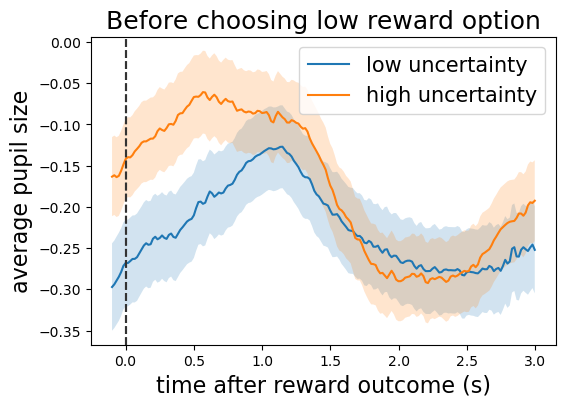

In [267]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'size_last_forced'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]
to_plot11 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == True)]
to_plot2 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]

to_plot1_trace = np.array(to_plot1[f'pupil_{event}'].to_list())
to_plot11_trace = np.array(to_plot11[f'pupil_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_outcome'], [to_plot1_trace,  to_plot2_trace], ['low uncertainty', 'high uncertainty'], 'Before choosing low reward option')

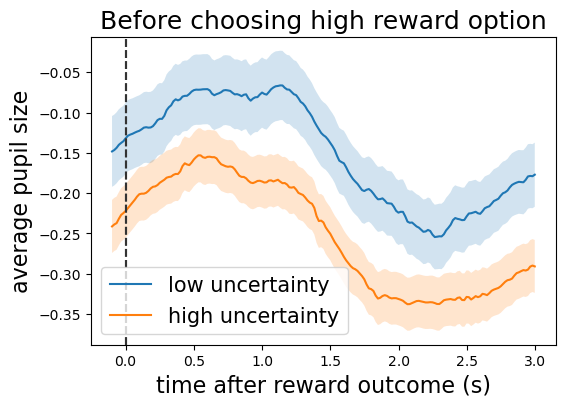

In [278]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'size_last_forced'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot11 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot2 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]

to_plot1_trace = np.array(to_plot1[f'pupil_{event}'].to_list())
to_plot11_trace = np.array(to_plot11[f'pupil_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_outcome'], [to_plot1_trace,  to_plot2_trace], ['low uncertainty', 'high uncertainty'], 'Before choosing high reward option')

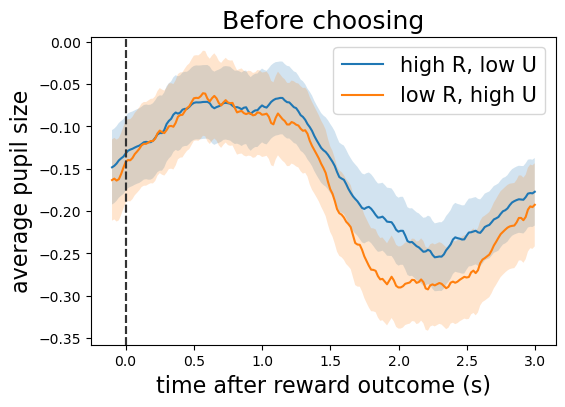

In [280]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'size_last_forced'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot11 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot2 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]

to_plot1_trace = np.array(to_plot1[f'pupil_{event}'].to_list())
to_plot11_trace = np.array(to_plot11[f'pupil_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_outcome'], [to_plot1_trace,  to_plot2_trace], ['high R, low U', 'low R, high U'], 'Before choosing')

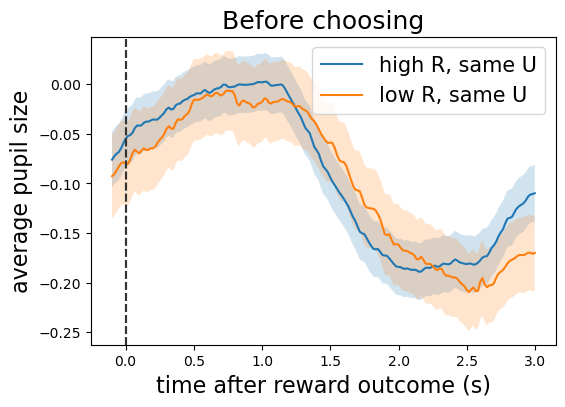

In [281]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'size_last_forced'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot11 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot2 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == True)]

to_plot1_trace = np.array(to_plot1[f'pupil_{event}'].to_list())
to_plot11_trace = np.array(to_plot11[f'pupil_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_outcome'], [to_plot1_trace,  to_plot2_trace], ['high R, same U', 'low R, same U'], 'Before choosing')

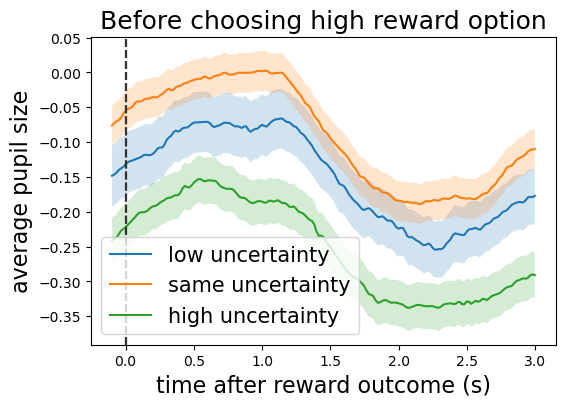

In [274]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'size_last_forced'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot11 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot2 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]

to_plot1_trace = np.array(to_plot1[f'pupil_{event}'].to_list())
to_plot11_trace = np.array(to_plot11[f'pupil_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_outcome'], [to_plot1_trace,to_plot11_trace,  to_plot2_trace], ['low uncertainty', 'same uncertainty','high uncertainty'], 'Before choosing high reward option')

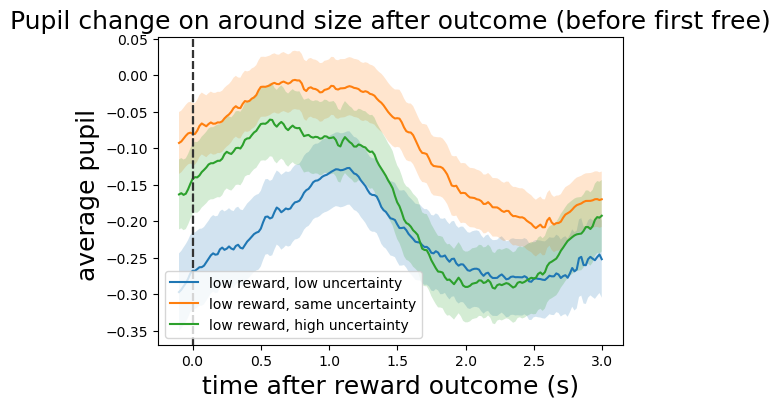

In [229]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'size_last_forced'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]
to_plot11 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == True)]
to_plot2 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]

to_plot1_trace = np.array(to_plot1[f'pupil_{event}'].to_list())
to_plot11_trace = np.array(to_plot11[f'pupil_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_outcome'], [to_plot1_trace, to_plot11_trace, to_plot2_trace], ['low reward, low uncertainty', 'low reward, same uncertainty', 'low reward, high uncertainty'], 'size after outcome (before first free)')

In [231]:
to_plot1.head(10)

sub  ratio_B  avg_reward_A  avg_reward_B first_free_choice  \
17   1     0.25     50.666667     67.000000                 0   
20   1     0.25     70.333333     74.000000                 0   
37   1     0.75     61.000000     44.666667                 1   
40   1     0.75     50.000000     30.333333                 1   
51   1     0.25     41.333333     46.000000                 0   
52   1     0.75     78.000000     62.000000                 1   
55   1     0.75     65.000000     64.000000                 1   
77   2     0.25     36.333333     62.000000                 0   
89   2     0.25     50.666667     67.000000                 0   
92   2     0.25     70.333333     74.000000                 0   

                                      first_3_choices  avg_reward_chosen  \
17  208    0
209    1
210    1
Name: choices_new, ...          50.666667   
20  244    0
245    0
246    0
Name: choices_new, ...          70.333333   
37  448    1
449    1
450    1
Name: choices_new, ...          44.666667   
40  484    1
485    0
486    0
Name: choices_new, ...          30.333333   
51  616    0
617    1
618    0
Name: choices_new, ...          41.333333   
52  628    1
629    0
630    1
Name: choices_new, ...          62.000000   
55  664    1
665    1
666    0
Name: choices_new, ...          64.000000   
77  160    0
161    1
162    1
Name: choices_new, ...          36.333333   
89  304    0
305    1
306    1
Name: choices_new, ...          50.666667   
92  340    0
341    0
342    1
Name: choices_new, ...          70.333333   

    high_uncertainty  high_reward  same_uncertainty  \
17               0.0          0.0               0.0   
20               0.0          0.0               0.0   
37               0.0          0.0               0.0   
40               0.0          0.0               0.0   
51               0.0          0.0               0.0   
52               0.0          0.0               0.0   
55               0.0          0.0               0.0   
77               0.0          0.0               0.0   
89               0.0          0.0               0.0   
92               0.0          0.0               0.0   

    pupil_size_avg_last_forced  pupil_change_avg_last_forced  \
17                    0.429532                     -0.697377   
20                   -1.341653                      0.800579   
37                    0.669856                      1.624828   
40                   -0.338963                     -0.289321   
51                   -0.216012                      0.491904   
52                   -0.054759                     -0.016638   
55                   -2.070941                      0.997456   
77                    0.206331                     -0.870596   
89                   -0.103859                      0.806242   
92                    1.247368                     -1.861162   

                               pupil_size_last_forced  \
17  [0.6471418700419554, 0.6489248674619622, 0.649...   
20  [-0.8387411834782795, -0.8495418425283895, -0....   
37  [-1.0468097751623706, -1.0361115321872738, -0....   
40  [0.04398703587876784, 0.03665766969501682, 0.0...   
51  [-0.39939320951354595, -0.3917848624907145, -0...   
52  [0.028273042955566617, 0.05365991302865756, 0....   
55  [-1.0146526651274468, -1.012882948038377, -1.0...   
77  [0.7598896928238507, 0.712600649349559, 0.6714...   
89  [-0.6198000547319391, -0.6374959541170331, -0....   
92  [2.0343163128753208, 2.0456933209747796, 2.055...   

                             pupil_change_last_forced  \
17  [-0.003424104074238099, -0.001641106654231339,...   
20  [0.036907235860745624, 0.026106576810635662, 0...   
37  [-0.110936309826001, -0.1002380668509042, -0.0...   
40  [0.024185723189843963, 0.016856357006092944, 0...   
51  [-0.022711505615802208, -0.015103158592970733,...   
52  [0.015125264013765457, 0.0405121340868564, 0.0...   
55  [0.06491289101202669, 0.0666826081010965, 0.00...   
77  [0.11031264881460368, 0.06302360534031204, 0.0...  

In [303]:
def grouping(df):
    average_per_sub = df.groupby('sub')['pupil_size_avg_pre_response_first_free'].mean()
    return np.array(average_per_sub)

In [304]:
average_per_sub = to_plot1.groupby('sub')['pupil_size_avg_pre_response_first_free'].mean()
np.array(average_per_sub)

array([-0.26959869, -0.21104566,  0.07837299, -0.14076499, -0.1328379 ,
       -0.40696563, -0.81891356, -0.67921481,  0.10280833, -0.33833711,
       -0.28966081,  0.08392177, -0.24336837, -0.19194049,  0.28680423,
        0.50410532,  0.07554571, -0.14589293, -0.19683673, -0.17193752,
       -0.0795739 , -0.22622282,  0.08993222,  0.31215206, -0.06990783,
        0.2677934 ,  0.01435999, -0.55551274, -0.86440807, -0.44179674,
       -0.95324381,  0.23364973,  0.1227128 , -0.16374234, -0.44180928,
       -0.17706787, -0.09344236, -0.52031174, -0.66211694,  0.27245263,
        0.37693775, -0.0738609 ,  0.24606716, -0.34796415,  0.44737381,
        0.03543387, -0.87840815, -0.15916606,  0.00361383,  0.14275389,
       -0.05528419])

[-0.14322281555119304, -0.0069967476435899515, -0.06790630894719396]
-1.0012756605945636 0.3215148122230798


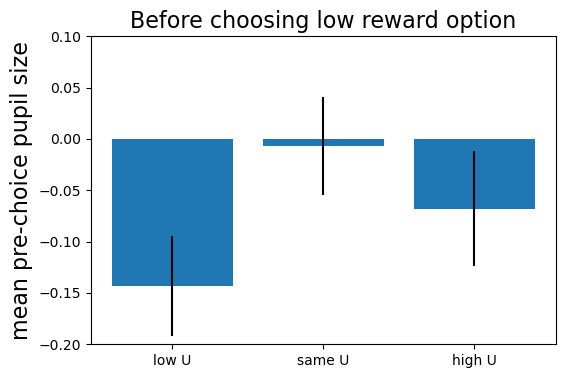

In [305]:
# for each subject, compute an average:
average_per_sub = to_plot1.groupby('sub')['pupil_size_avg_pre_response_first_free'].mean()
average_per_sub


# potential problem: did not know that the next choice is free???

# instead, do a bar plot

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))


labels = ['low U', 'same U', 'high U']

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'pupil_size_avg_pre_response_first_free'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]
to_plot2 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == True)]
to_plot3 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]


all_to_plot = [to_plot1, to_plot2, to_plot3]
num_bars = len(labels)
y1 = []
y1_se = []
for i in range(num_bars):
    # bar plot
    y1_or = np.array(grouping(all_to_plot[i]))
        

    y1.append(np.mean(y1_or,axis=0))
    y1_se.append(stats.sem(y1_or))

        #y1_se.append(np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))
#labels_short = ['stay_b',  'switch_b', 'stay_w','switch_w']
ax4.bar(labels, y1, yerr = y1_se)
#ax4.set_ylim([0,1])


# compute ANOVA
#y1_all = [X_acc[0], X_acc[1], X_acc[2]]
FF, pp = stats.f_oneway(all_to_plot[0][event], all_to_plot[1][event], all_to_plot[2][event])
k, pp = stats.ttest_rel(grouping(all_to_plot[0]), grouping(all_to_plot[2]))
ax4.set_title(f'Before choosing low reward option', fontsize=16)
ax4.set_ylabel('mean pre-choice pupil size', fontsize=16)
ax4.set_ylim([-0.2, 0.1])
print(y1)
print(k, pp)

[-0.1474397627393831, -0.05176368292215855, -0.0408566875257341]
-1.5904427481021468 0.112235101770173


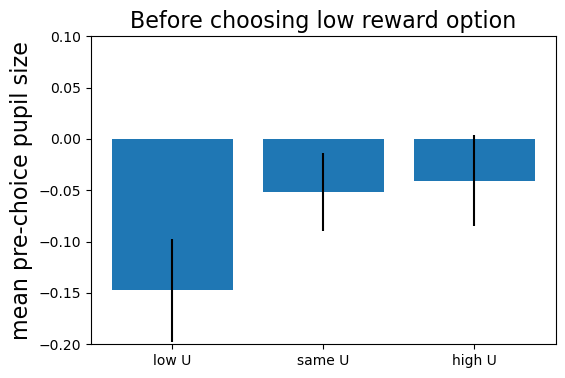

In [308]:
# potential problem: did not know that the next choice is free???

# instead, do a bar plot

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))


labels = ['low U', 'same U', 'high U']

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'pupil_size_avg_pre_response_first_free'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]
to_plot2 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == False) & (joint_data[types[2]] == True)]
to_plot3 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]


all_to_plot = [to_plot1, to_plot2, to_plot3]
num_bars = len(labels)
y1 = []
y1_se = []
for i in range(num_bars):
    # bar plot
    y1_or = np.array(all_to_plot[i][event])
        

    y1.append(np.mean(y1_or,axis=0))
    y1_se.append(stats.sem(y1_or))

        #y1_se.append(np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))
#labels_short = ['stay_b',  'switch_b', 'stay_w','switch_w']
ax4.bar(labels, y1, yerr = y1_se)
#ax4.set_ylim([0,1])


# compute ANOVA
#y1_all = [X_acc[0], X_acc[1], X_acc[2]]
FF, pp = stats.f_oneway(all_to_plot[0][event], all_to_plot[1][event], all_to_plot[2][event])
k, pp = stats.ttest_ind(all_to_plot[0][event], all_to_plot[2][event])
ax4.set_title(f'Before choosing low reward option', fontsize=16)
ax4.set_ylabel('mean pre-choice pupil size', fontsize=16)
ax4.set_ylim([-0.2, 0.1])
print(y1)
print(k, pp)

[-0.031040716546893898, -0.06790630894719396]
0.4923486658829448 0.6235520911800081


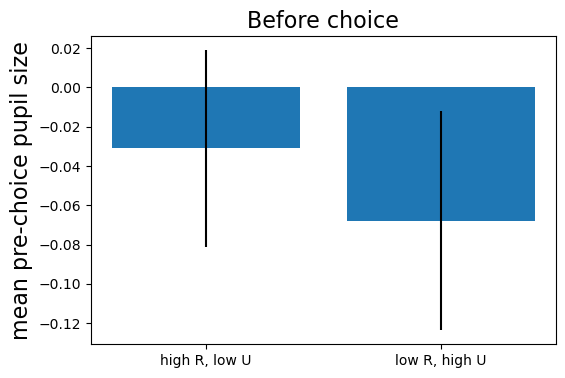

In [309]:
# potential problem: did not know that the next choice is free???

# instead, do a bar plot

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))


labels = ['high R, low U', 'low R, high U']

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'pupil_size_avg_pre_response_first_free'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot2 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot3 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]


all_to_plot = [to_plot1, to_plot3]
num_bars = len(labels)
y1 = []
y1_se = []
for i in range(num_bars):
    # bar plot
    y1_or = np.array(grouping(all_to_plot[i]))
        

    y1.append(np.mean(y1_or,axis=0))
    y1_se.append(stats.sem(y1_or))

        #y1_se.append(np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))
#labels_short = ['stay_b',  'switch_b', 'stay_w','switch_w']
ax4.bar(labels, y1, yerr = y1_se)
#ax4.set_ylim([0,1])


# compute ANOVA
#y1_all = [X_acc[0], X_acc[1], X_acc[2]]
#FF, pp = stats.f_oneway(all_to_plot[0][event], all_to_plot[1][event], all_to_plot[2][event])
k, pp = stats.ttest_ind(grouping(all_to_plot[0]), grouping(all_to_plot[1]))
ax4.set_title(f'Before choice', fontsize=16)
ax4.set_ylabel('mean pre-choice pupil size', fontsize=16)
#ax4.set_ylim([-0.2, 0.1])
print(y1)
print(k, pp)

[0.013119851241441946, 0.02202173281945116]
-0.16543057655851298 0.8686522465066832


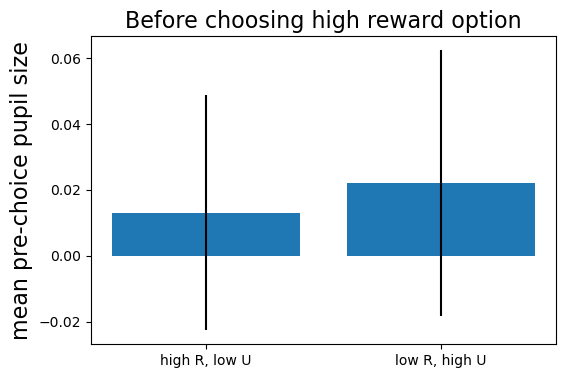

In [310]:
# potential problem: did not know that the next choice is free???

# instead, do a bar plot

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))


labels = ['high R, low U', 'low R, high U']

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'pupil_size_avg_response_first_free'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot2 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot3 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == False) & (joint_data[types[2]] == False)]


all_to_plot = [to_plot1, to_plot3]
num_bars = len(labels)
y1 = []
y1_se = []
for i in range(num_bars):
    # bar plot
    y1_or = np.array(all_to_plot[i][event])
        

    y1.append(np.mean(y1_or,axis=0))
    y1_se.append(stats.sem(y1_or))

        #y1_se.append(np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))
#labels_short = ['stay_b',  'switch_b', 'stay_w','switch_w']
ax4.bar(labels, y1, yerr = y1_se)
#ax4.set_ylim([0,1])


# compute ANOVA
#y1_all = [X_acc[0], X_acc[1], X_acc[2]]
#FF, pp = stats.f_oneway(all_to_plot[0][event], all_to_plot[1][event], all_to_plot[2][event])
k, pp = stats.ttest_ind(all_to_plot[0][event], all_to_plot[1][event])
ax4.set_title(f'Before choosing high reward option', fontsize=16)
ax4.set_ylabel('mean pre-choice pupil size', fontsize=16)
#ax4.set_ylim([-0.2, 0.1])
print(y1)
print(k, pp)

[-0.004482873518427509, 0.03722529508733818, -0.10850808937004637]
1.9509969600616717 0.051302542143400645


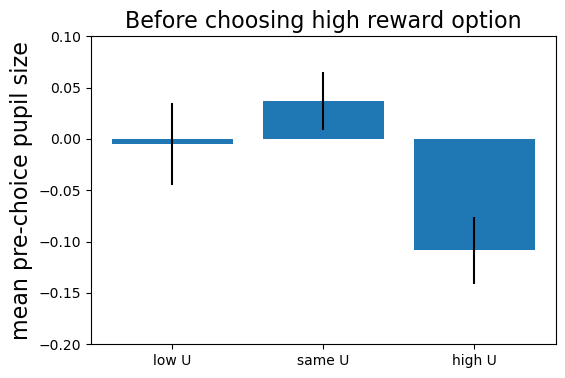

In [312]:
# potential problem: did not know that the next choice is free???

# instead, do a bar plot

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))


labels = ['low U', 'same U', 'high U']

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'pupil_size_avg_pre_response_first_free'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot2 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot3 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]


all_to_plot = [to_plot1, to_plot2, to_plot3]
num_bars = len(labels)
y1 = []
y1_se = []
for i in range(num_bars):
    # bar plot
    y1_or = np.array(all_to_plot[i][event])
        

    y1.append(np.mean(y1_or,axis=0))
    y1_se.append(stats.sem(y1_or))

        #y1_se.append(np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))
#labels_short = ['stay_b',  'switch_b', 'stay_w','switch_w']
ax4.bar(labels, y1, yerr = y1_se)
#ax4.set_ylim([0,1])


# compute ANOVA
#y1_all = [X_acc[0], X_acc[1], X_acc[2]]
FF, pp = stats.f_oneway(all_to_plot[0][event], all_to_plot[1][event], all_to_plot[2][event])
k, pp = stats.ttest_ind(all_to_plot[0][event], all_to_plot[2][event])
ax4.set_title(f'Before choosing high reward option', fontsize=16)
ax4.set_ylabel('mean pre-choice pupil size', fontsize=16)
ax4.set_ylim([-0.2, 0.1])
print(y1)
print(k, pp)

[0.013119851241441946, 0.06124378953515049, -0.05473428392546974]
[0.013119851241441946, 0.06124378953515049, -0.05473428392546974]
1.4046331323480539 0.16040327993770126


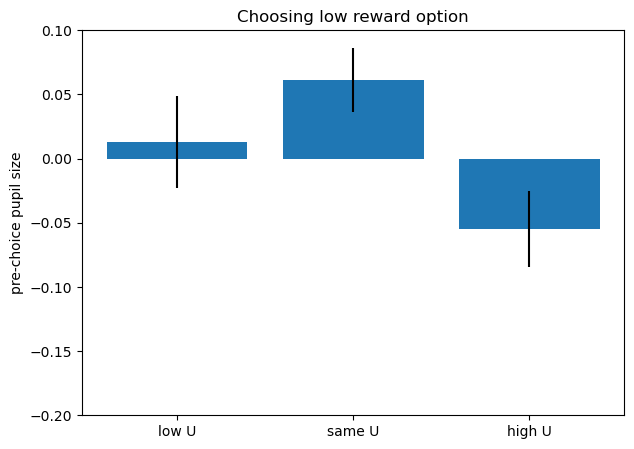

In [246]:
# potential problem: did not know that the next choice is free???

# instead, do a bar plot

gridsize = (1,1)
fig = plt.figure(figsize=(7, 5))
ax4 = plt.subplot2grid(gridsize, (0, 0))


labels = ['low U', 'same U', 'high U']

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'pupil_size_avg_response_first_free'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot2 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == True)]
to_plot3 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]


all_to_plot = [to_plot1, to_plot2, to_plot3]
num_bars = len(labels)
y1 = []
y1_se = []
for i in range(num_bars):
    # bar plot
    y1_or = np.array(all_to_plot[i][event])
        

    y1.append(np.mean(y1_or,axis=0))
    y1_se.append(stats.sem(y1_or))

        #y1_se.append(np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0)))
#labels_short = ['stay_b',  'switch_b', 'stay_w','switch_w']
ax4.bar(labels, y1, yerr = y1_se)
#ax4.set_ylim([0,1])


# compute ANOVA
#y1_all = [X_acc[0], X_acc[1], X_acc[2]]
#FF, pp = stats.f_oneway(X_acc[0], X_acc[1], X_acc[2], X_acc[3], X_acc[4],  X_acc[5])
ax4.set_title(f'Choosing high reward option')
ax4.set_ylabel('pre-choice pupil size')
#ax4.set_ylim([-0.1, 0.15])
print(y1)
FF, pp = stats.f_oneway(all_to_plot[0][event], all_to_plot[1][event], all_to_plot[2][event])
k, pp = stats.ttest_ind(all_to_plot[0][event], all_to_plot[2][event])
ax4.set_title(f'Choosing low reward option')
ax4.set_ylabel('pre-choice pupil size')
ax4.set_ylim([-0.2, 0.1])
print(y1)
print(k, pp)

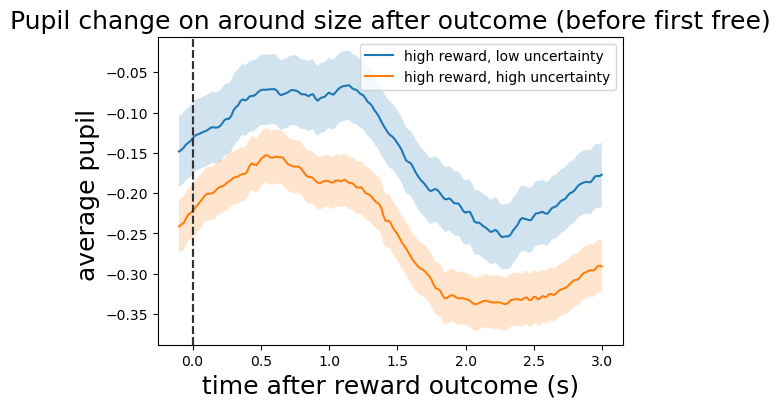

In [227]:
# read t_epochs

tt = open(proj_dir+"/t_epochs.pkl","rb")
t_epochs = pickle.load(tt)
t_epochs.keys()

# plot the pupil trace based on trial types
types = ['high_uncertainty', 'high_reward', 'same_uncertainty']
event = 'size_last_forced'

joint_data = df_forced
to_plot1 = joint_data[(joint_data[types[0]] == False) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]
to_plot2 = joint_data[(joint_data[types[0]] == True) & (joint_data[types[1]] == True) & (joint_data[types[2]] == False)]

to_plot1_trace = np.array(to_plot1[f'pupil_{event}'].to_list())
to_plot2_trace = np.array(to_plot2[f'pupil_{event}'].to_list())
                           
y_test = plot_pupil_responses(t_epochs['t_outcome'], [to_plot1_trace, to_plot2_trace], ['high reward, low uncertainty', 'high reward, high uncertainty'], 'size after outcome (before first free)')

In [219]:
# 
# now group the forced trial groups 

# 1. choosing the high uncertain option
# 2. choosing the higher reward option
# 3. choosing the high uncertain but low reward (explore?)

# choosing high uncertain but low reward (choosing B, when A > B and ratio B < 0.5)
# risky and not good (want more info)
df_high_uncertain_low_reward_B = df_forced[(df_forced['ratio_B'] < 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] > df_forced['avg_reward_B']) ]
df_high_uncertain_low_reward_A = df_forced[(df_forced['ratio_B'] > 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] < df_forced['avg_reward_B']) ]

df_high_uncertain_same_reward_B = df_forced[(df_forced['ratio_B'] < 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] == df_forced['avg_reward_B']) ]
df_high_uncertain_same_reward_A = df_forced[(df_forced['ratio_B'] > 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] == df_forced['avg_reward_B']) ]

# risky but good
df_high_uncertain_high_reward_B = df_forced[(df_forced['ratio_B'] < 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] < df_forced['avg_reward_B']) ]
df_high_uncertain_high_reward_A = df_forced[(df_forced['ratio_B'] > 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] > df_forced['avg_reward_B']) ]


#### add: equal certain:

df_same_uncertain_low_reward_B = df_forced[(df_forced['ratio_B'] == 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] > df_forced['avg_reward_B']) ]
df_same_uncertain_low_reward_A = df_forced[(df_forced['ratio_B'] == 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] < df_forced['avg_reward_B']) ]
df_same_uncertain_same_reward_B = df_forced[(df_forced['ratio_B'] == 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] == df_forced['avg_reward_B']) ]
df_same_uncertain_same_reward_A = df_forced[(df_forced['ratio_B'] == 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] == df_forced['avg_reward_B']) ]

df_same_uncertain_high_reward_B = df_forced[(df_forced['ratio_B'] == 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] < df_forced['avg_reward_B']) ]
df_same_uncertain_high_reward_A = df_forced[(df_forced['ratio_B'] == 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] > df_forced['avg_reward_B']) ]


# for sure not good (?)
df_low_uncertain_low_reward_B = df_forced[(df_forced['ratio_B'] > 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] > df_forced['avg_reward_B']) ]
df_low_uncertain_low_reward_A = df_forced[(df_forced['ratio_B'] < 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] < df_forced['avg_reward_B']) ]

df_low_uncertain_same_reward_B = df_forced[(df_forced['ratio_B'] > 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] == df_forced['avg_reward_B']) ]
df_low_uncertain_same_reward_A = df_forced[(df_forced['ratio_B'] < 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] == df_forced['avg_reward_B']) ]

# safe and good
df_low_uncertain_high_reward_B = df_forced[(df_forced['ratio_B'] > 0.5) & (df_forced['first_free_choice'] == 1) & (df_forced['avg_reward_A'] < df_forced['avg_reward_B']) ]
df_low_uncertain_high_reward_A = df_forced[(df_forced['ratio_B'] < 0.5) & (df_forced['first_free_choice'] == 0) & (df_forced['avg_reward_A'] > df_forced['avg_reward_B']) ]

high_uncertain_low_reward_count = len(df_high_uncertain_low_reward_B) + len(df_high_uncertain_low_reward_A)
high_uncertain_high_reward_count = len(df_high_uncertain_high_reward_B) + len(df_high_uncertain_high_reward_A)
high_uncertain_same_reward_count = len(df_high_uncertain_same_reward_B) + len(df_high_uncertain_same_reward_A)


low_uncertain_low_reward_count = len(df_low_uncertain_low_reward_B) + len(df_low_uncertain_low_reward_A)
low_uncertain_high_reward_count = len(df_low_uncertain_high_reward_B) + len(df_low_uncertain_high_reward_A)
low_uncertain_same_reward_count = len(df_low_uncertain_same_reward_B) + len(df_low_uncertain_same_reward_A)


same_uncertain_low_reward_count = len(df_same_uncertain_low_reward_B) + len(df_same_uncertain_low_reward_A)
same_uncertain_high_reward_count = len(df_same_uncertain_high_reward_B) + len(df_same_uncertain_high_reward_A)
same_uncertain_same_reward_count = len(df_same_uncertain_same_reward_B) + len(df_same_uncertain_same_reward_A)




In [223]:
df_low_uncertain_high_reward_B

sub  ratio_B  avg_reward_A  avg_reward_B first_free_choice  \
2      1     0.75          57.0     68.000000                 1   
14     1     0.75          46.0     65.333333                 1   
130    3     0.75          57.0     68.000000                 1   
157    3     0.75          83.0     85.666667                 1   
171    3     0.75          34.0     67.666667                 1   
202    4     0.75          57.0     68.000000                 1   
213    4     0.75          83.0     85.666667                 1   
227    4     0.75          34.0     67.666667                 1   
262    6     0.75          46.0     65.333333                 1   
326    8     0.75          46.0     65.333333                 1   
330    8     0.75          57.0     68.000000                 1   
373    8     0.75          83.0     85.666667                 1   
390   10     0.75          46.0     65.333333                 1   
394   10     0.75          57.0     68.000000                 1   
403   10     0.75          34.0     67.666667                 1   
462   11     0.75          46.0     65.333333                 1   
470   11     0.75          16.0     20.000000                 1   
509   11     0.75          83.0     85.666667                 1   
522   12     0.75          57.0     68.000000                 1   
531   12     0.75          34.0     67.666667                 1   
565   12     0.75          83.0     85.666667                 1   
594   13     0.75          57.0     68.000000                 1   
662   14     0.75          46.0     65.333333                 1   
691   14     0.75          34.0     67.666667                 1   
709   16     0.75          83.0     85.666667                 1   
739   16     0.75          34.0     67.666667                 1   
811   19     0.75          34.0     67.666667                 1   
818   19     0.75          57.0     68.000000                 1   
837   20     0.75          83.0     85.666667                 1   
867   20     0.75          34.0     67.666667                 1   
886   20     0.75          46.0     65.333333                 1   
890   20     0.75          57.0     68.000000                 1   
909   21     0.75          83.0     85.666667                 1   
923   21     0.75          34.0     67.666667                 1   
930   21     0.75          57.0     68.000000                 1   
942   21     0.75          46.0     65.333333                 1   
965   22     0.75          83.0     85.666667                 1   
979   22     0.75          34.0     67.666667                 1   
998   22     0.75          46.0     65.333333                 1   
1002  22     0.75          57.0     68.000000                 1   
1037  23     0.75          83.0     85.666667                 1   
1051  23     0.75          34.0     67.666667                 1   
1093  24     0.75          83.0     85.666667                 1   
1107  24     0.75          34.0     67.666667                 1   
1162  25     0.75          57.0     68.000000                 1   
1189  25     0.75          83.0     85.666667                 1   
1198  25     0.75          16.0     20.000000                 1   
1203  25     0.75          34.0     67.666667                 1   
1234  26     0.75          57.0     68.000000                 1   
1245  26     0.75          83.0     85.666667                 1   
1259  26     0.75          34.0     67.666667                 1   
1290  27     0.75          57.0     68.000000                 1   
1302  27     0.75          46.0     65.333333                 1   
1310  27     0.75          16.0     20.000000                 1   
1315  27     0.75          34.0     67.666667                 1   
1333  27     0.75          83.0     85.666667                 1   
1362  28     0.75          57.0     68.000000                 1   
1371  28     0.75          34.0     67.666667                 1   
1389  28     0.75          83.0     85.666667       

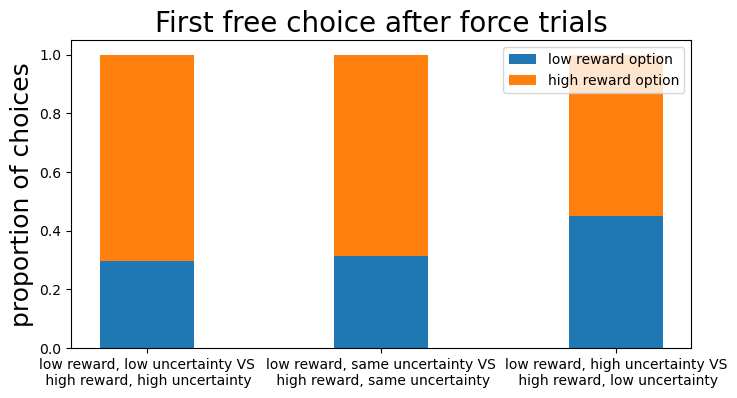

In [221]:
#np.count_nonzero((df_forced['ratio_B'] < 0.5) & (df_forced['first_free_choice'] == 1))

# grid setup
total_type1 = low_uncertain_low_reward_count + high_uncertain_high_reward_count
total_type2 = high_uncertain_low_reward_count + low_uncertain_high_reward_count
total_type3 = same_uncertain_low_reward_count + same_uncertain_high_reward_count

gridsize = (1,1)
fig = plt.figure(figsize=(8,4))
ax = plt.subplot2grid(gridsize, (0, 0))
#bar_label = ['low uncertainty', 'same uncertainty', 'high uncertainty']
bar_label = ['low reward, low uncertainty VS\n high reward, high uncertainty', 'low reward, same uncertainty VS\n high reward, same uncertainty', 'low reward, high uncertainty VS\n high reward, low uncertainty']
#low_rewards = [low_uncertain_low_reward_count,same_uncertain_low_reward_count, high_uncertain_low_reward_count]
#same_rewards = [low_uncertain_same_reward_count, same_uncertain_same_reward_count, high_uncertain_same_reward_count]
#high_rewards = [low_uncertain_high_reward_count, same_uncertain_high_reward_count, high_uncertain_high_reward_count]

low_rewards = [low_uncertain_low_reward_count/total_type1,  same_uncertain_low_reward_count/total_type3, high_uncertain_low_reward_count/total_type2]
high_rewards = [high_uncertain_high_reward_count/total_type1, same_uncertain_high_reward_count/total_type3, low_uncertain_high_reward_count/total_type2]
ax.bar(bar_label, low_rewards, width=0.4, label = 'low reward option')
ax.bar(bar_label, high_rewards, width=0.4, bottom = np.array(low_rewards), label = 'high reward option')
#ax.bar(bar_label, same_rewards, width=0.4, bottom = low_rewards, label = 'same rewards')
#ax.set_xlabel('number of trials until switch',fontsize=14)
ax.set_ylabel('proportion of choices',fontsize=18)
ax.set_title(f'First free choice after force trials',fontsize=20)
#ax.set_ylim([0,1])
ax.legend(fontsize=10)
plt.show()

In [222]:
low_rewards

[0.29633113828786456, 0.31343283582089554, 0.44866385372714485]

In [ ]:
# plot the average for all subjects

types = ['free', 'forced']
metric = 'size'
event = 'outcome'
label = f'pupil_{metric}_{event}'

Y_to_plot = []
for sub in valid_sub-1:
    joint_data = joint_data_by_sub[f'sub{sub+1}']
    
    
    to_plot1 = joint_data[joint_data[types[0]] == True]
    to_plot2 = joint_data[joint_data[types[1]] == True]
    
    Y = [to_plot1, to_plot2]
    
    num_lines = len(Y)
    Y_all = []
    for i in range(num_lines):
        y1_or = np.array(Y[i][label].to_list())
        
        y1 = np.mean(y1_or,axis=0)
        #y1_se = np.std(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

        #ax4.plot(x, y1, label=labels[i])
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        
        Y_all.append(y1)
    
    Y_to_plot.append(Y_all)
    
Y_to_plot = np.array(Y_to_plot)
print(Y_to_plot.shape)

gridsize = (1,1)
fig = plt.figure(figsize=(6, 4))
ax4 = plt.subplot2grid(gridsize, (0, 0))

num_sub, num_lines, num_points = Y_to_plot.shape
x = t_epochs[f't_{event}']

for i in range(num_lines):
    y1_or = Y_to_plot[:,i,:]
        
    y1 = np.nanmean(y1_or,axis=0)
    y1_se = np.nanstd(y1_or,axis=0) / np.sqrt(np.size(y1_or, axis=0))

    ax4.plot(x, y1, label=types[i])
    ax4.axvline(x=0,color=".2", linestyle="--")

    ax4.fill_between(x,y1-y1_se, y1+y1_se, alpha=0.2)

ax4.set_title(f'Pupil {metric} around {event}',fontsize=20) #Pupil change to different change points 
ax4.set_ylabel(f'average pupil {metric}',fontsize=18)
ax4.set_xlabel(f'time after {event} (s)',fontsize=18)
ax4.set_ylim([-0.35, 0.35])
ax4.legend(prop={"size":16})
plt.legend()
        

#### 1. Compare pupil with RPE

In [18]:
joint_data_all.columns

Index(['level_0', 'index', 'trial', 'rt', 'pupil_baseline_start',
       'pupil_baseline_outcome', 'pupil_size_pre_response',
       'pupil_size_avg_pre_response', 'pupil_size_response',
       'pupil_size_avg_response', 'pupil_size_outcome',
       'pupil_size_avg_outcome', 'pupil_baseline_start_avg',
       'pupil_baseline_outcome_avg', 'pupil_change_pre_response',
       'pupil_change_avg_pre_response', 'pupil_change_response',
       'pupil_change_avg_response', 'pupil_change_outcome',
       'pupil_change_avg_outcome', 'pupil_change_avg_outcome1',
       'pupil_change_avg_outcome2', 'pupil_change_avg_outcome_nassar',
       'pupil_change_avg_outcome3', 'pupil_change_avg_response_nassar',
       'pupil_change_avg_response3', 'rt_next', 'trial', 'choices',
       'choices_new', 'outcomes', 'mean_A', 'mean_B', 'mean_chosen',
       'mean_unchosen', 'forced', 'free', 'valid', 'SD', 'changepoints',
       'trial', 'RPE', 'ER_chosen_before', 'ER_chosen_after',
       'EU_chosen_before',

In [25]:
joint_data_all['SD'] == 10

0        False
1        False
2        False
3        False
4        False
         ...  
36762     True
36763     True
36764     True
36765     True
36766     True
Name: SD, Length: 36767, dtype: bool

In [53]:
# plot a scatterplot with all the trials for all subjects (use joint_data_all)

def plot_scatter(df, x_label, y_label, bins=150, grouped_by=None):

    # get all types of conditions
    conditions = df[grouped_by].unique()


    gridsize = (1,2)
    fig = plt.figure(figsize=(10, 4))
    ax = plt.subplot2grid(gridsize, (0, 0))



    for i in range(len(conditions)):
        #ax = plt.subplot2grid(gridsize, (0, 0))

        data_by_condition = df[df[grouped_by] == conditions[i]]
        x = data_by_condition[x_label]
        y = data_by_condition[y_label]

        label = grouped_by + '=' + str(conditions[i])

        ax.scatter(x, y, label=label, s=1)
        #ax4.axvline(x=0,color=".2", linestyle="--")

        #ax4.fill_between(epoch_time,y1-y1_se, y1+y1_se, alpha=0.2)
        

        ax.set_title('',fontsize=18) #Pupil change to different change points 
        ax.set_ylabel(y_label,fontsize=18)
        ax.set_xlabel(x_label,fontsize=18)
        #ax4.set_ylim([-0.08, 0.08])
        ax.legend(prop={"size":16})
        plt.legend()

        

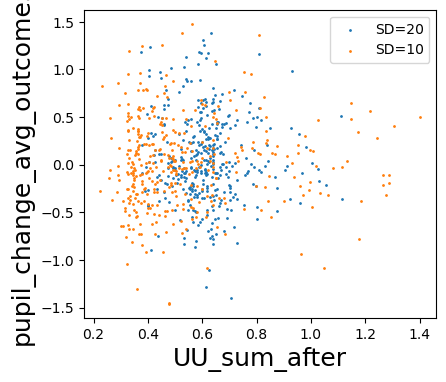

In [54]:
plot_scatter(joint_data_by_sub['sub1'], 'UU_sum_after','pupil_change_avg_outcome3', grouped_by='SD')